This notebook is made in test purposes for teaching practice in NUST MISIS. Original code by sumitmukhija https://github.com/sumitmukhija/Titanic/

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import zipfile
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

zf = zipfile.ZipFile('./titanic.zip') 

trd  = pd.read_csv(zf.open('train.csv'))
tsd = pd.read_csv(zf.open('test.csv'))
td = pd.concat([trd, tsd], ignore_index=True, sort  = False)

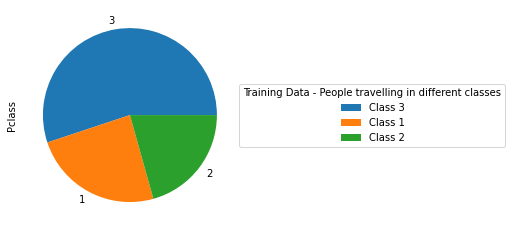

In [20]:
fig_pclass = trd.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("Training Data - People travelling in different classes")

In [21]:
pclass_1_survivor_distribution = round((trd[trd.Pclass == 1].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 1]) * 100, 2)
pclass_2_survivor_distribution = round((trd[trd.Pclass == 2].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 2]) * 100, 2)
pclass_3_survivor_distribution = round((trd[trd.Pclass == 3].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 3]) * 100, 2)

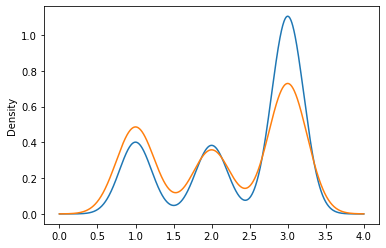

In [22]:
for x in ["male","female"]:
    td.Pclass[td.Sex == x].plot(kind="kde")

In [23]:
td.Embarked.fillna(td.Embarked.mode()[0], inplace = True)

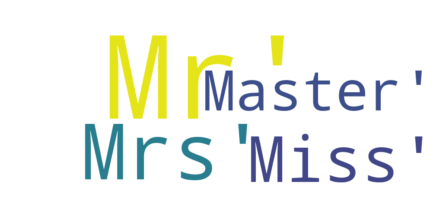

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Sir               1
the Countess      1
Lady              1
Jonkheer          1
Capt              1
Don               1
Mme               1
Dona              1
Name: Salutation, dtype: int64

In [24]:
td['Salutation'] = td.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
td.Salutation.nunique()
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(td.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

td.Salutation.value_counts()

In [25]:
grp = td.groupby(['Sex', 'Pclass'])  
td.Age = grp.Age.apply(lambda x: x.fillna(x.median()))

#If still any row remains
td.Age.fillna(td.Age.median, inplace = True)

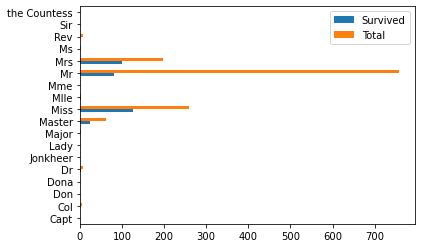

In [26]:

sal_df = pd.DataFrame({
    "Survived":
    td[td.Survived == 1].Salutation.value_counts(),
    "Total":
        td.Salutation.value_counts()
})
s = sal_df.plot.barh()

In [27]:
td.Cabin = td.Cabin.fillna('NA')
td['Age_Range'] = pd.cut(td.Age, [0, 10, 20, 30, 40, 50, 60, 70, 80])

In [28]:
td['Family'] = td.Parch + td.SibSp
td['Is_Alone'] = td.Family == 0

In [29]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid',
                                                                                      'High_Mid','High'])

Text(0.5, 1.0, 'Training Data - Survival based on embarking point.')

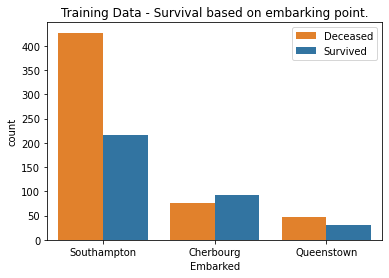

In [30]:
p = sns.countplot(x = "Embarked", hue = "Survived", data = trd, palette=["C1", "C0"])
p.set_xticklabels(["Southampton","Cherbourg","Queenstown"])
p.legend(labels = ["Deceased", "Survived"])
p.set_title("Training Data - Survival based on embarking point.")

In [31]:
td = pd.concat([td,pd.get_dummies(td.Cabin, prefix="Cabin"),pd.get_dummies(td.Age_Range, prefix="Age_Range"), pd.get_dummies(td.Embarked, prefix="Emb", drop_first = True), pd.get_dummies(td.Salutation, prefix="Title", drop_first = True),pd.get_dummies(td.Fare_Category, prefix="Fare", drop_first = True), pd.get_dummies(td.Pclass, prefix="Class", drop_first = True)], axis=1)
td['Sex'] = LabelEncoder().fit_transform(td['Sex'])
td['Is_Alone'] = LabelEncoder().fit_transform(td['Is_Alone'])

In [32]:
td.drop(['Pclass', 'Fare','Cabin', 'Fare_Category','Name','Salutation', 'Ticket','Embarked', 'Age_Range', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)

NB Accuracy: 67.6%
The cross validated score for GNB is: 64.88


Text(0.5, 1.05, 'Confusion_matrix for NB')

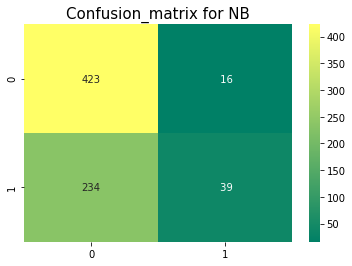

In [33]:
#Data to be predicted
X_to_be_predicted = td[td.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)

#Training data
train_data = td
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train  = train_data.drop(['Survived'], axis = 1)
train_data.shape #891 x 28

##Gaussian
clf = GaussianNB()
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("NB Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for GNB is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for NB', y=1.05, size=15)


In [34]:
result = clf.predict(X_to_be_predicted)
submission = pd.DataFrame({'PassengerId':X_to_be_predicted.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'titanic-predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: titanic-predictions.csv
